In [1]:
# %source '/home/hershel/root/root-6.26.00/install/bin/thisroot.sh'
import os
import sys
import ROOT

ROOT.EnableImplicitMT(True) # 4
# ROOT.gInterpreter.GenerateDictionary("ROOT::VecOps::RVec<vector<double>>", "vector")
# ROOT.gInterpreter.Declare("ROOT::VecOps::RVec<vector<double>> bla;")
# ROOT.gSystem.Load("liblibs.so")
# ROOT.gSystem.Load("libQPixRTD.so")

def getRDFs(isofs):
    """
    function to create a dictionary of RDF's based on the isotope files handed to it
    """
    iso_rdfs = {}
    for isotope, files in isofs.items():
        iso_rdfs[isotope] = ROOT.RDataFrame("event_tree", files)

    return iso_rdfs

def getIsotopeFiles(fs):
    """
    this function should be able to return a RDF that corresponds to the preprend
    isotope
    """
    isotopes = set()

    # file structor is: /path/to/dir/00/iso_name_file.root
    # therefore rpartition for / and then partition on _ to separate for iso
    for f in fs:
        isotope = f.rpartition("/")[2].partition("_")
        isotopes.add(isotope[0])

    # create a dictionary of isotope to files
    isotope_files = {}
    for iso in isotopes:
        isotope_files[iso] = [f for f in fs if iso in f]

    return isotope_files


def getRootFiles():
    """
    this function should walk the radiogenic directory and spit back the file path
    of all ROOT files:

    note: you should be one directory above radiogenic
    """

    files = []
    for rs, ds, fs in os.walk("/home/hershel/QPix/radiogenic"): # change to data directory
        f = [f for f in fs if "root" in f]
        if f:
            f = [os.path.join(rs, f) for f in f ]
            files.extend(f)

    return files

def defineFilters(rdfs, xmin=80, xmax=120, ymin=80, ymax=120, event = 1455):
    """
    function takes in rdf dictionary and should define timestamp branch ond then filter
    on data to get the interesting events, or events that have timestamps at all
    """

    ROOT.gInterpreter.Declare("std::string isoname;")
    for iso, rdf in rdfs.items():
        ROOT.isoname = iso;
        rdfs[iso] = rdf.Define("Isotope", f'return isoname;')\
                       .Filter(f"""bool found = false; 
                                 for(auto x : pixel_x) 
                                   if(x > {xmin} && x < {xmax}) found = true; 
                                 return found;""")\
                       .Filter(f"""bool found = false; 
                                 for(auto y : pixel_y) 
                                   if(y > {ymin} && y < {ymax}) found = true; 
                                 return found;""")\
                    #    .Filter(f"""bool found = false; 
                    #                if(event == {event}) found = true; 
                    #              return found;""")
              
# run == some number maybe 00

    return rdfs

def main():
    files = getRootFiles()
    print(files[:10], len(files))

    isotopes = getIsotopeFiles(files)
    for k,v in isotopes.items():
        print(k, len(v))

    rdfs = getRDFs(isotopes)

    # figure out the interesting branch names in the tree
    branchNames = set()

    rdfs = defineFilters(rdfs)

    npData = {}
    for iso, rdf in rdfs.items():
        print(iso, rdf.GetColumnNames())
        # for col in rdf.GetColumnNames():
            # print(col, rdf.GetColumnType(col))
        # rdf.Snapshot("event_tree", f'./scripts/output_data/{iso}_sim.root')

        print(rdf.Count().GetValue())
        h1 = rdf.Histo1D("event")
        # c1 = ROOT.TCanvas()
        h1.Draw()
        # c1.Draw()
        # print('histo has been drawn')
        npData[iso] = rdf.AsNumpy(["pixel_x", "pixel_y", "pixel_tslr", "pixel_reset", "run", "event"])

    for iso, data in npData.items():
        for col, npd in data.items():
            print(iso ,col, len(npd))
    
    return npData

    # input("waiitng..")



# if __name__ == "__main__":
#     main()


Welcome to JupyROOT 6.26/00


In [2]:
%pwd
os.chdir('/home/hershel/QPix/')

data = main()


['/home/hershel/QPix/radiogenic/41/Rn222_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/K40_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Ar39_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Ar42_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Bi214_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Pb214_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/K42_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Po210_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Co60_rtd_slim_000041.root', '/home/hershel/QPix/radiogenic/41/Kr85_rtd_slim_000041.root'] 1000
K42 100
Po210 100
Pb214 100
Ar42 100
K40 100
Rn222 100
Co60 100
Ar39 100
Bi214 100
Kr85 100
K42 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
5
Po210 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
0
Pb214 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


6014


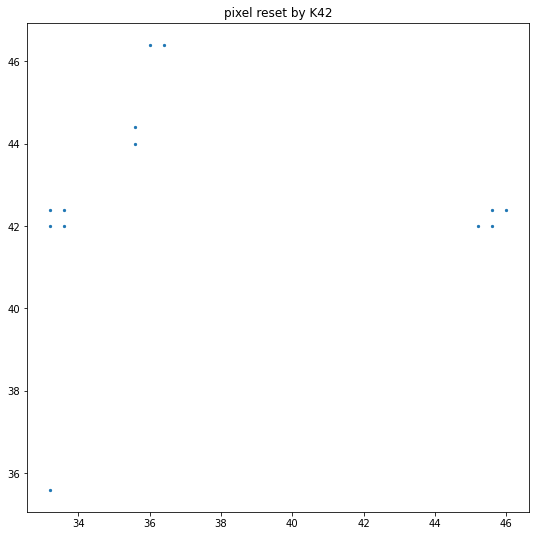

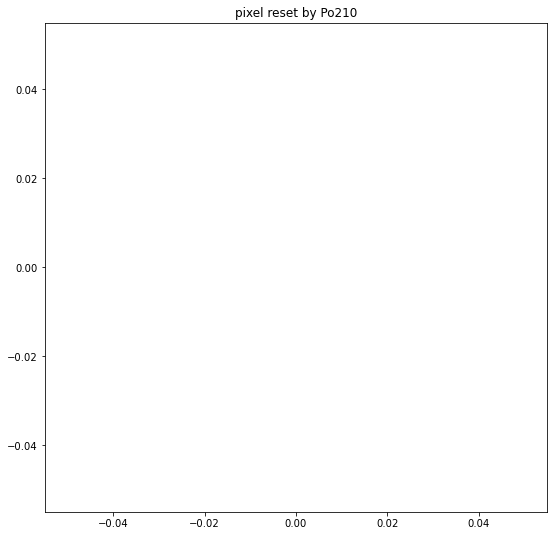

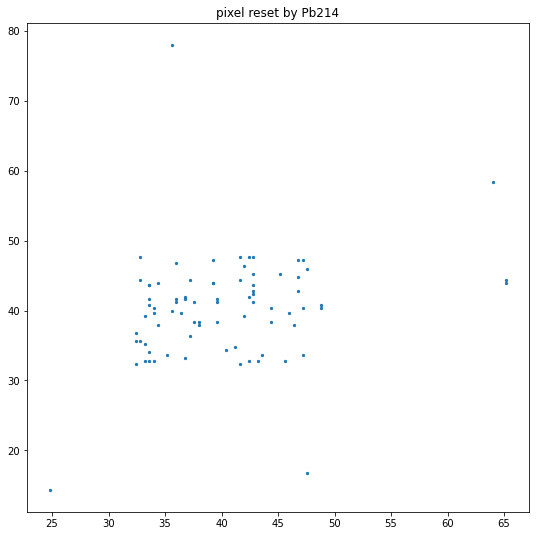

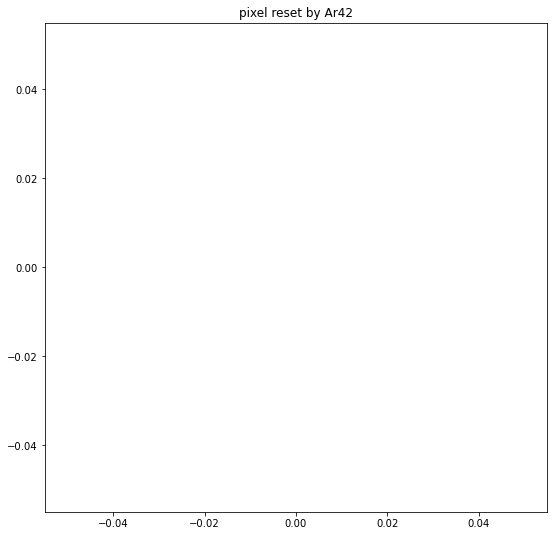

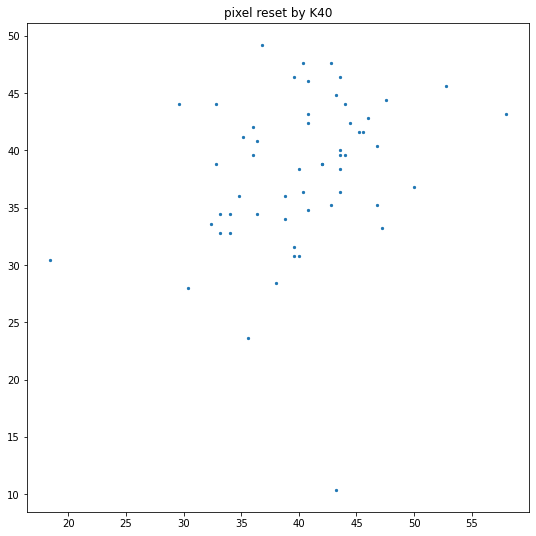

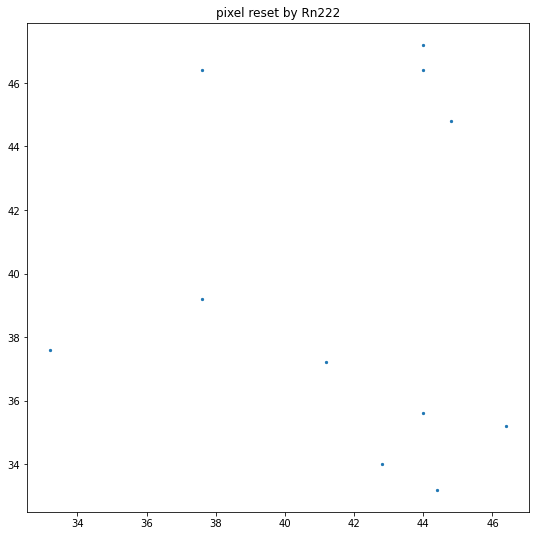

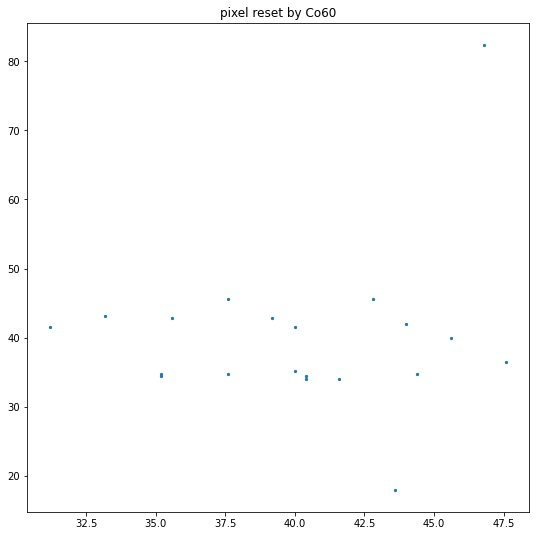

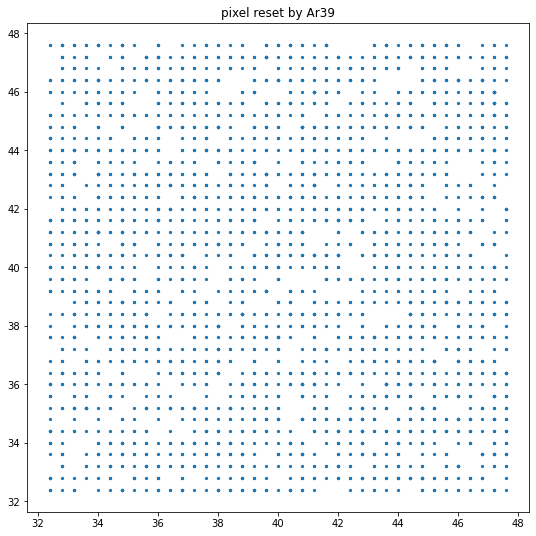

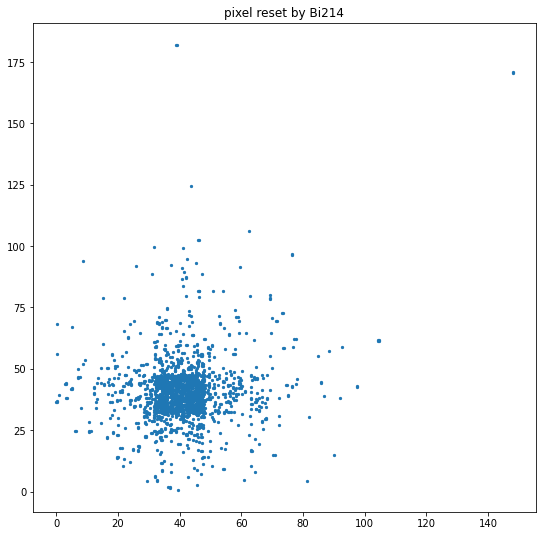

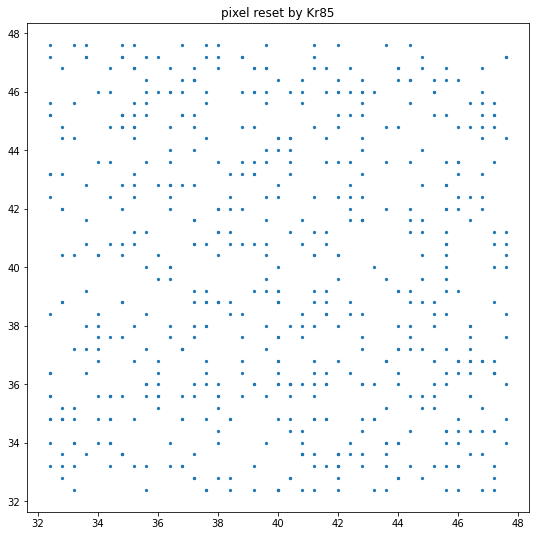

In [3]:
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
import itertools


x_values = {}
y_values = {}
pixel_size = 0.4 # converts pixels to cm

for key, entries in data.items():
    if not hasattr(x_values, f'{key}'):
        x_values[key] = []
        y_values[key] = []

    x_values[key] = list(itertools.chain(*data[key]['pixel_x']*pixel_size))
    y_values[key] = list(itertools.chain(*data[key]['pixel_y']*pixel_size))

    # for value in data[key]['pixel_x']:
    #     x_values[key].append(value)
    # for value in data[key]['pixel_y']:
    #     y_values[key].append(value)
    
    plt.figure(figsize = (9, 9))
    plt.scatter(x_values[key], y_values[key], s=5)
    plt.title(f'pixel reset by {key}')

    # sea.scatterplot(x_values[key], y_values[key], hue=data[key]['pixel_reset'])
# for key in x_values.keys():
#     print()
#     if (len(x_values[key])):
#         print(key)
#         print(max(x_values[key]))
#         print(max(y_values[key]))
#     else:
#         continue
sump = 0
for key in x_values.keys():
    sump+=len(x_values[key])
print(sump)

In [4]:
class pixelEvents():
    def __init__(self, x, y, hitTimes, event, ion):
        self.x = x
        self.y = y
        self.hitTimes = hitTimes
        self.ion = ion
        self.event = event

pixel_size = 0.4 # converts pixels to cm
# ListOfPixelHits = []
MemoizedEvents = {}
LargestEventTest = {}

for ion in data.keys():
    for ind, dastuff in enumerate(data[ion]['pixel_reset']):
        x = data[ion]['pixel_x'][ind] * pixel_size
        y = data[ion]['pixel_y'][ind] * pixel_size
        ev = data[ion]['event'][ind]

        if ev not in MemoizedEvents:
            MemoizedEvents[f'{ev}'] = []
            LargestEventTest[f'{ev}'] = 0

        if not(len(x) > 1):
            ResetTimes = []
            for i in data[ion]['pixel_reset'][ind]:
                for j in i:
                    ResetTimes.append(j)
            newObj = pixelEvents(x=x[0], y=y[0], hitTimes=ResetTimes, ion=ion, event=ev)
            # ListOfPixelHits.append(newObj)
            MemoizedEvents[f'{ev}'].append(newObj)
            
        else:
            for n, m in zip(x, y):
                # print(f'n is {n} and m is {m}')
                ResetTimes = []
                for i in data[ion]['pixel_reset'][ind]:
                    for j in i:
                        ResetTimes.append(j)

                newObj = pixelEvents(x=n, y=m, hitTimes=ResetTimes, ion=ion, event=ev)
                # ListOfPixelHits.append(newObj)
                MemoizedEvents[f'{ev}'].append(newObj)
        
        for obj in MemoizedEvents[f'{ev}']:
            # print(f'the x and y coords of this hit are {obj.x} and {obj.y}')
            addTo = len(obj.hitTimes)
            print(obj.hitTimes)
            # print(f'the value to add is {addTo}')
            LargestEventTest[f'{ev}']+=addTo
            
curGreatest = 0
for event in LargestEventTest:
    test = LargestEventTest[event]
    if test > curGreatest:
        # print(f'the new current greatest number of pixel resets is {test} at event {event}')
        curGreatest = test

[8.860193010766514]
[6.997561196084759, 6.997562546084751, 6.997561949558519, 6.9975635195585095, 6.997560869572584, 6.997562039572577, 6.99756164507814, 6.997563255078131]
[6.997561196084759, 6.997562546084751, 6.997561949558519, 6.9975635195585095, 6.997560869572584, 6.997562039572577, 6.99756164507814, 6.997563255078131]
[6.997561196084759, 6.997562546084751, 6.997561949558519, 6.9975635195585095, 6.997560869572584, 6.997562039572577, 6.99756164507814, 6.997563255078131]
[6.997561196084759, 6.997562546084751, 6.997561949558519, 6.9975635195585095, 6.997560869572584, 6.997562039572577, 6.99756164507814, 6.997563255078131]
[2.750637241428118, 2.750637621428116, 2.7506381614281126, 2.7506371071291844, 2.75063785712918]
[2.750637241428118, 2.750637621428116, 2.7506381614281126, 2.7506371071291844, 2.75063785712918]
[7.816998256185367, 7.816998946185363, 7.816998558681784, 7.816997702631062, 7.816997992631061, 7.816998212631059, 7.816998462631058, 7.816999052631054, 7.816996255081194, 7.

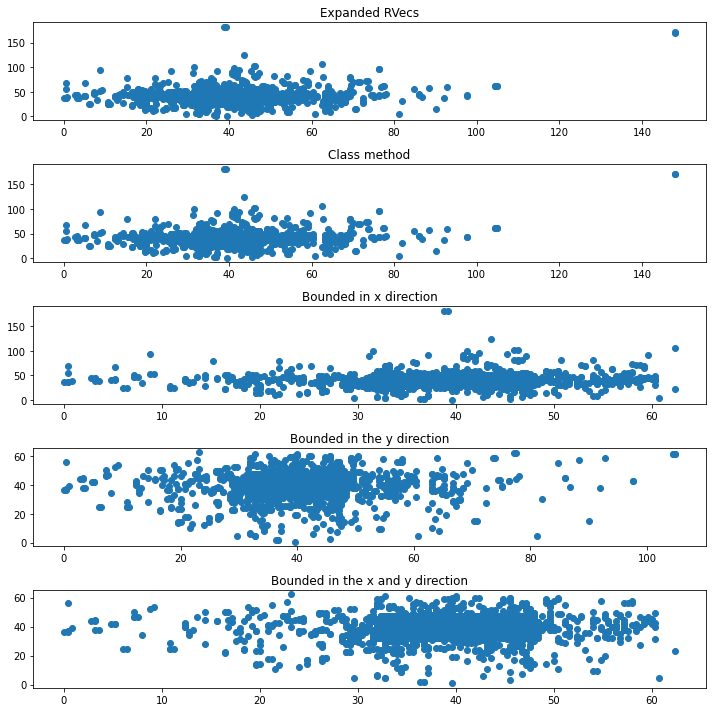

In [5]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import sys

# TESTING IF THE DATA MATCHES
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
pixel_size = 0.4
x_values = {}
y_values = {}
pixel_reset = {}

length = 0
for key, entries in data.items():
    if not hasattr(x_values, f'{key}'):
        x_values[key] = []
        y_values[key] = []
        pixel_reset[key] = []

    x_values[key] = list(itertools.chain(*data[key]['pixel_x'] * pixel_size)) 
    length+=len(x_values[key])
    y_values[key] = list(itertools.chain(*data[key]['pixel_y'] * pixel_size)) 

    ax[0].scatter(x_values[key], y_values[key], color='#1f77b4')
    ax[0].set_title('Expanded RVecs')
# print(length)

#Numpy way  
ListOfPixelHits = []
for keys in MemoizedEvents.keys():
    ListOfPixelHits.extend(MemoizedEvents[keys])
x_val = np.zeros_like(ListOfPixelHits)
y_val = np.zeros_like(ListOfPixelHits)
hitTimes = []
events = []
for ind, hit in enumerate(ListOfPixelHits):
    x_val[ind] = hit.x
    y_val[ind] = hit.y
    events.append([hit.event])
    hitTimes.append([hit.hitTimes])


ax[1].scatter(x_val, y_val)
ax[1].set_title('Class method')

xbound = 62.5
ybound = 62.5
XLogicalArray = np.logical_and(x_val >= 0, x_val < xbound)
ax[2].scatter(x_val[XLogicalArray], y_val[XLogicalArray])
ax[2].set_title('Bounded in x direction')
YLogicalArray = np.logical_and(y_val >= 0, y_val < ybound)
ax[3].scatter(x_val[YLogicalArray], y_val[YLogicalArray])
ax[3].set_title('Bounded in the y direction')

LogicalArray = np.logical_and(YLogicalArray, XLogicalArray)
ax[4].scatter(x_val[LogicalArray], y_val[LogicalArray])
ax[4].set_title('Bounded in the x and y direction')

plt.tight_layout()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
# import sys

ncols = 8
nrows = 8
xBottom = int(0)
xTop = int(150)
yBottom = int(0)
yTop = int(250)
colWidth = int((xTop - xBottom)/ncols) # what the x and y bounds are 
rowWidth = int((yTop - yBottom)/nrows)

Columns = []
for cols in range(ncols):
    IndexingArray = np.logical_and(x_val >= xBottom + colWidth * (cols), x_val < xBottom + colWidth * (cols+1)) 
    # print(f'the sum for the columns arrays are {sum(IndexingArray)}')
    locals() [f'Col{cols}'] = IndexingArray
    # print(f'the bottom index is {xBottom + colWidth * (cols)}')
    Columns.append(locals() [f'Col{cols}'])
# print(Col0)
# print(len(Col0))

Entries = []
for rows in range(nrows):
    IndexingArray = np.logical_and(y_val >= yTop - rowWidth * (rows+1), y_val < yTop - rowWidth * rows)
    for colsInd, cols in enumerate(Columns):
        index = colsInd + rows * ncols
        # IndexingArray = np.logical_and(y_val >= yBottom + rowWidth * rows, y_val < yBottom + rowWidth * (rows+1))
        locals() [f'Entry{index}'] = [j for j in cols * IndexingArray]
        Entries.append(locals() [f'Entry{index}'])


TotalIndexList = []
TotalHitTimesList = []
TotalXList = []
TotalYList = []
SplitXList = []
SplitYList = []
for ind, entry in enumerate(Entries):
 
    # print(f'the x and y coord for ind {ind} is ({xcoord}, {ycoord}) ')
    x = x_val[entry]
    y = y_val[entry]
    TruncedHitTimes = [i for indx,i in enumerate(hitTimes) if entry[indx] == True]

    TotalHitTimesList.append(TruncedHitTimes)
    TotalIndexList.append(ind)
    TotalXList.extend(x)
    TotalYList.extend(y)
    SplitXList.append(x)
    SplitYList.append(y)

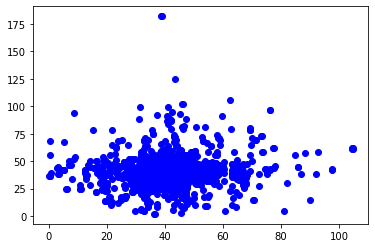

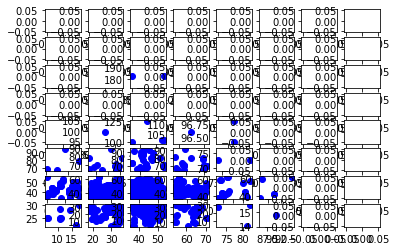

In [58]:
import matplotlib
matplotlib.use('tkagg')
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots(1)
ax1.scatter(TotalXList, TotalYList, color='blue')
plt.figure().show()

for ind in np.arange(nrows*ncols):    # print(f'the ind is now {ind}')
    ax2 = plt.subplot(nrows, ncols, ind+1)#, sharex=ax2, sharey=ax2)
    ax2.scatter(SplitXList[ind], SplitYList[ind], color='blue')

# for ax in ax2.get_axes():
#     ax.label_outer()
# ax2.gcf().set_size_inches(10,10)

# ax2.show()

In [ ]:
# outPath = '/home/hershel/QPix/Outfiles/'
# saveFile = open(outPath+f'InjectHitsData.txt', 'w')
# # 
# for hits, ind in zip(TotalHitTimesList, TotalIndexList):
#     saveFile.write(str(hits)+'\t'+str(ind)+'\n')
# # 
# saveFile.close()

Signature: plt.subplot(*args, **kwargs)
Docstring:
Add an Axes to the current figure or retrieve an existing Axes.

This is a wrapper of `.Figure.add_subplot` which provides additional
behavior when working with the implicit API (see the notes section).

Call signatures::

   subplot(nrows, ncols, index, **kwargs)
   subplot(pos, **kwargs)
   subplot(**kwargs)
   subplot(ax)

Parameters
----------
*args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
    The position of the subplot described by one of

    - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
      *index* position on a grid with *nrows* rows and *ncols* columns.
      *index* starts at 1 in the upper left corner and increases to the
      right. *index* can also be a two-tuple specifying the (*first*,
      *last*) indices (1-based, and including *last*) of the subplot, e.g.,
      ``fig.add_subplot(3, 1, (1, 2))`` makes a subplot that spans the
      upper 2/3 of the figure.
    - 